In [36]:
import io
import os
import re
import zipfile
import pickle
from urllib.request import urlopen
from urllib.parse import urlparse

import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
plt.style.use('style.mplstyle')


## Classifications from ClimateBert

In [37]:
def summation_score(classifier, weight):
   classifier[classifier > 0] *= weight
   try:
      score = sum(classifier) / len(classifier)
      return score
   except:
      return np.nan


In [38]:
with open('climatebert_parameters.pkl', 'rb') as f:
    parameters = pickle.load(f)

In [39]:
data = pd.read_csv('climatebert_speeches.csv')
unweighted_scores = [summation_score(parameters[key], 1) for key in parameters.keys()]

data['unweighted_scores'] = unweighted_scores
data['probability_score'] = 0.5*(data['unweighted_scores'] + 1)

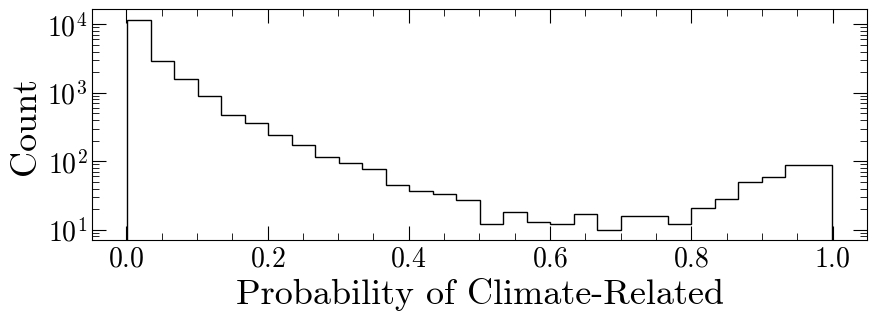

In [40]:
plt.figure(figsize=(10,3))
plt.hist(data['probability_score'], color = 'k', histtype='step', bins=30)
plt.xlabel('Probability of Climate-Related')
plt.ylabel('Count')
plt.yscale('log')

In [41]:
climate_mask = np.all([data['probability_score'] > 0.5], axis=0)
print(f'no. climate-related: {len(data[climate_mask])}')

no. climate-related: 458


## Classifications from GPT

In [42]:
with open('gpt_responses.pkl', 'rb') as f:
    parameters = pickle.load(f)

In [43]:
# analyze all the times that GPT returned non-standard answers
fails = {}
for key, speech in parameters.items():
    fails[key] = []
    for ii, response in enumerate(speech):
        response[0] = response[0].lower()
        response[0] = re.sub(r'[^\w\s]', '', response[0])
        if response[0] not in ['yes', 'no' ]:
            fails[key].append([ii, response[0]])
fails = {key: value for key, value in fails.items() if value != []}
print(f"Failure rate: {len(fails) / len(parameters)*10:2.2f}%")

Failure rate: 0.20%


In [44]:
# Clean the malformatted answers out
for key, index_list in fails.items():
    if key in parameters:
        # Retrieve indices from dict1 for the current key
        indices_to_delete = {item[0] for item in index_list}
        # Filter out elements in dict2[key] whose index is not in indices_to_delete
        parameters[key] = [item for i, item in enumerate(parameters[key]) if i not in indices_to_delete]

In [45]:
classifier = {'yes' : 1, 'no' : 0}

keys, class_max, class_avg, summs, lengths = [], [], [], [], []
for key, item in parameters.items():
    vals = np.array(item)[:,0]
    number_vals = [classifier[val] for val in vals]

    maximum = np.max(number_vals)
    summ = sum(number_vals)
    length = len(number_vals)

    keys.append(key)
    class_max.append(maximum)
    class_avg.append(summ / length)
    summs.append(summ)
    lengths.append(length)
classification = pd.DataFrame({
    'id' : keys,
    'gpt_maximum_classification' : class_max,
    'gpt_average_classification' : class_avg,
    'gpt_sum' : summs,
    'gpt_length' : lengths
})

In [46]:
full_data = pd.merge(data, classification, on="id")

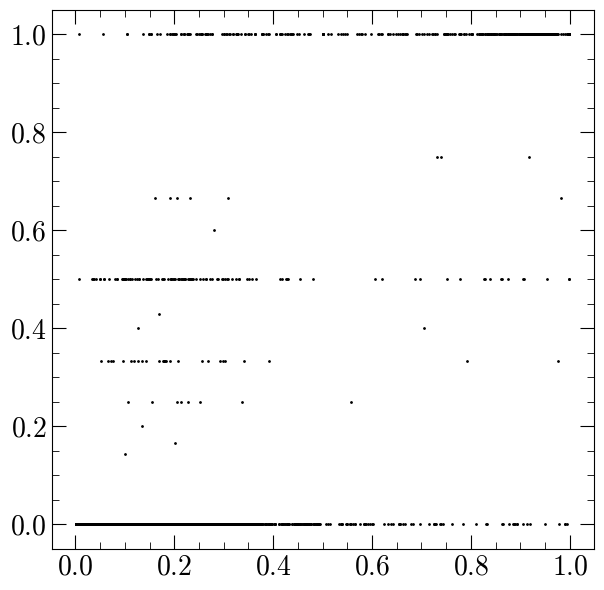

In [47]:
plt.scatter(full_data.probability_score, full_data.gpt_average_classification, c = 'k', s = 1)

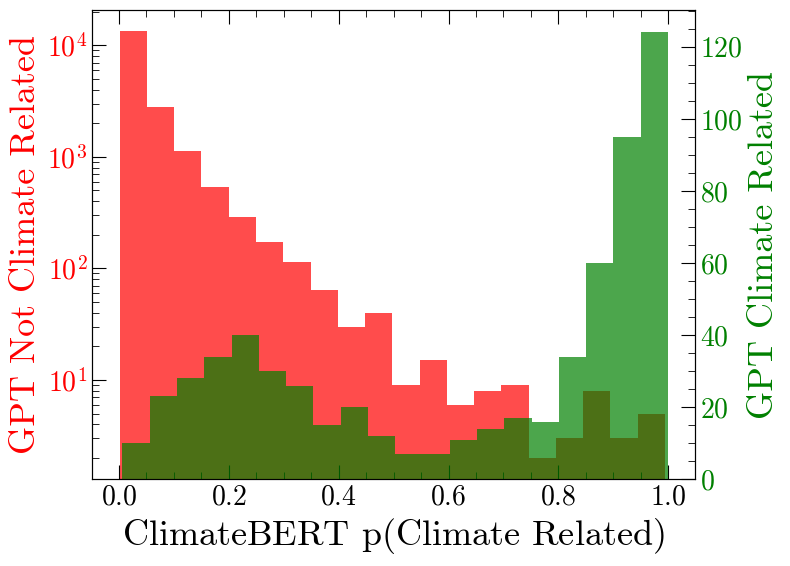

In [54]:
import joypy

gpt_yes = full_data.query("gpt_maximum_classification == 1")
gpt_no = full_data.query("gpt_maximum_classification == 0")

fig, ax1 = plt.subplots(figsize=(8, 6))

ax1.hist(gpt_no.probability_score, bins=20, color='red', alpha=0.7, label = 'GPT No')
ax1.set_ylabel("GPT Not Climate Related", color='red')
ax1.tick_params(axis='y', labelcolor='red')
ax1.set_yscale('log')

# Plot histograms in each subplot
ax2 = ax1.twinx()
ax2.hist(gpt_yes.probability_score, bins=20, color='green', alpha=0.7, label="GPT Yes")
ax2.set_ylabel("GPT Climate Related", color='green')
ax2.tick_params(axis='y', labelcolor='green')

ax1.set_xlabel(r'ClimateBERT $p(\text{Climate Related})$')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [57]:
bert_no_gpt_yes = gpt_yes.query("probability_score < 0.5")
bert_no_gpt_yes.to_csv("../data/bert_no_gpt_yes.csv")

bert_yes_gpt_no = gpt_no.query("probability_score > 0.5")
bert_yes_gpt_no.to_csv("../data/bert_yes_gpt_no.csv")

In [56]:
disagreement

,Unnamed: 0,url,title,description,date,author,id,climatebert_scores,unweighted_scores,probability_score,gpt_maximum_classification,gpt_average_classification,gpt_sum,gpt_length
5193,492,https://www.bis.org/review/r080609a.pdf,Jean-Claude Trichet: Reflections on the curren...,"Keynote address by Mr Jean-Claude Trichet, Pre...",2008-06-04 00:00:00,Jean-Claude Trichet,r080609a,-0.809202,-0.899919,0.050040,1,0.500000,1,2
5609,37,https://www.bis.org/review/r091217b.pdf,Jean-Claude Trichet: Systemic risk,Text of the Clare Distinguished Lecture in Eco...,2009-12-10 00:00:00,Jean-Claude Trichet,r091217b,-0.750145,-0.867530,0.066235,1,0.333333,1,3
7288,868,https://www.bis.org/review/r100219c.pdf,Duvvuri Subbarao: Financial crises and the imp...,"Welcome remarks by Dr Duvvuri Subbarao, Govern...",2010-02-15 00:00:00,Duvvuri Subbarao,r100219c,-0.477824,-0.727072,0.136464,1,0.500000,1,2
8173,804,https://www.bis.org/review/r110311d.pdf,Axel A Weber: Lessons learnt - the reform of f...,"Speech by Professor Axel A Weber, President of...",2011-03-10 00:00:00,Axel A Weber,r110311d,-0.986463,-0.986463,0.006769,1,0.500000,1,2
11558,387,https://www.bis.org/review/r150807b.htm,Ravi Menon: An economic history of Singapore -...,"Keynote address by Mr Ravi Menon, Managing Dir...",2015-08-05 00:00:00,Ravi Menon,r150807b,-0.290737,-0.639984,0.180008,1,0.500000,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18983,193,https://www.bis.org/review/r240426g.htm,Christine Lagarde: IMFC statement,"Statement by Ms Christine Lagarde, President o...",2024-04-19 00:00:00,Christine Lagarde,r240426g,0.031019,-0.462158,0.268921,1,1.000000,1,1
19013,223,https://www.bis.org/review/r240426w.htm,Klaas Knot: Financial stability risks and the ...,"Speech by Mr Klaas Knot, Chair of the Financia...",2024-04-26 00:00:00,Klaas Knot,r240426w,-0.102780,-0.544415,0.227792,1,1.000000,1,1
19048,258,https://www.bis.org/review/r240515h.htm,Jessica Chew Cheng Lian: Special keynote addre...,Special keynote address by Ms Jessica Chew Che...,2024-05-14 00:00:00,Jessica Chew Cheng Lian,r240515h,0.501821,-0.246634,0.376683,1,1.000000,1,1
19096,306,https://www.bis.org/review/r240531d.htm,Anna Breman: Monetary policy decision-making,"Speech by Ms Anna Breman, First Deputy Governo...",2024-05-30 00:00:00,Anna Breman,r240531d,-0.319151,-0.643885,0.178058,1,0.333333,1,3
